# Non-orthogonal curvilinear coordinates

In this notebook we solve Poisson's equation on a 2D wavy domain, using non-orthogonal basis vectors.

In [1]:
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import Math
from shenfun import *
from shenfun.la import Solver2D

Define the non-orthogonal curvilinear coordinates. Here `psi=(u, v)` are the new coordinates and `rv` is the position vector

$$
\vec{r} = u \mathbf{i} + v\left(1- \frac{\sin 2u}{10} \right) \mathbf{j}
$$

where $\mathbf{i}$ and $\mathbf{j}$ are the Cartesian unit vectors in $x$- and $y$-directions, respectively.

In [2]:
u = sp.Symbol('x', real=True, positive=True)
v = sp.Symbol('y', real=True)
psi = (u, v)
rv = (u, v*(1-sp.sin(2*u)/10))

Now choose basis functions and create tensor product space. Notice that one has to use complex Fourier space and not the real, because the integral measure is a function of u.

In [3]:
N = 20
#B0 = FunctionSpace(N, 'C', bc=(0, 0), domain=(0, 2*np.pi))
B0 = FunctionSpace(N, 'F', dtype='D', domain=(0, 2*np.pi))
B1 = FunctionSpace(N, 'L', bc=(0, 0), domain=(-1, 1))

T = TensorProductSpace(comm, (B0, B1), dtype='D', coordinates=(psi, rv, sp.Q.negative(sp.sin(2*u)-10) & sp.Q.negative(sp.sin(2*u)/10-1)))
p = TrialFunction(T)
q = TestFunction(T)
b = T.coors.get_covariant_basis()
T.coors.sg

1 - sin(2*x)/10

In [4]:
sp.Matrix(T.coors.get_covariant_metric_tensor())

Matrix([
[      y**2*cos(2*x)**2/25 + 1, y*(sin(2*x) - 10)*cos(2*x)/50],
[y*(sin(2*x) - 10)*cos(2*x)/50,        (sin(2*x)/2 - 5)**2/25]])

In [5]:
Math(T.coors.latex_basis_vectors(covariant=True, symbol_names={u: 'u', v: 'v'}))

<IPython.core.display.Math object>

Plot the mesh to see the domain.

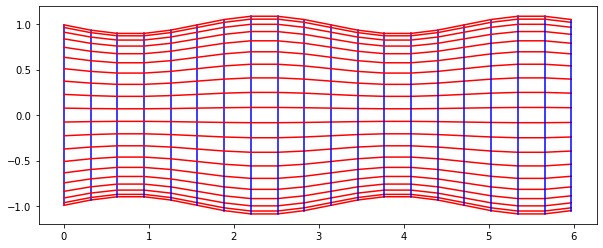

In [6]:
mesh = T.local_cartesian_mesh()
x, y = mesh
plt.figure(figsize=(10, 4))
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.plot(xi, yi, 'b')
    plt.plot(x[:, i], y[:, i], 'r')

Print the Laplace operator in curvilinear coordinates. We use `replace` to simplify the expression.

In [7]:
dp = div(grad(p))
g = sp.Symbol('g', real=True, positive=True)
replace = [(1-sp.sin(2*u)/10, sp.sqrt(g)), (sp.sin(2*u)-10, -10*sp.sqrt(g)), (5*sp.sin(2*u)-50, -50*sp.sqrt(g))]
Math((dp*T.coors.sg**2).tolatex(funcname='p', symbol_names={u: 'u', v: 'v'}, replace=replace))

<IPython.core.display.Math object>

Solve Poisson's equation. First define a manufactured solution and assemble the right hand side

In [8]:
ue = sp.sin(2*u)*(1-v**2)
f = (div(grad(p))).tosympy(basis=ue, psi=psi)
fj = Array(T, buffer=f*T.coors.sg)
f_hat = Function(T)
f_hat = inner(q, fj, output_array=f_hat)

Then assemble the left hand side and solve using a generic 2D solver

In [9]:
M = inner(q, div(grad(p))*T.coors.sg, level=2)
#M = inner(grad(q*T.coors.sg), -grad(p), level=2)
u_hat = Function(T)
Sol1 = Solver2D(M)
u_hat = Sol1(f_hat, u_hat)
uj = u_hat.backward()
uq = Array(T, buffer=ue)
print('Error =', np.linalg.norm(uj-uq))

Error = 6.0574486030738534e-15


In [10]:
for i in range(len(M)):
    print(len(M[i].mats[0].keys()), len(M[i].mats[1].keys()), M[i].mats[0].measure, M[i].mats[1].measure)

9 3 (sin(2*x) - 10)**2 1
4 3 -cos(2*x) x
4 3 -sin(2*x)*cos(2*x) x
4 3 sin(2*x) x
5 3 sin(2*x)**2 x
5 3 cos(2*x)**2 x
1 1 1 1
5 3 cos(2*x)**2 x**2


Plot the solution in the wavy Cartesian domain

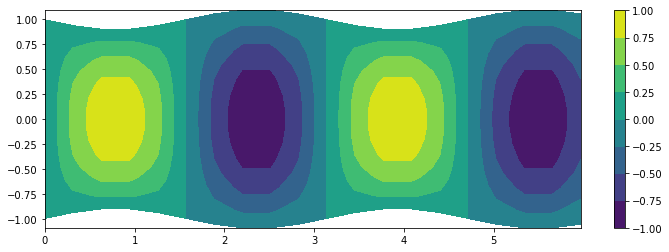

In [11]:
xx, yy = T.local_cartesian_mesh()
plt.figure(figsize=(12, 4))
plt.contourf(xx, yy, uj.real)
plt.colorbar()

Inspect the sparsity pattern of the generated matrix on the left hand side

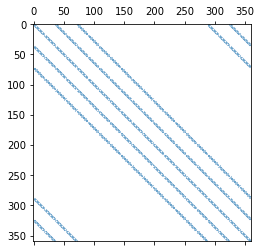

In [12]:
from matplotlib.pyplot import spy
plt.figure()
spy(Sol1.M, markersize=0.1)

In [13]:
from scipy.sparse.linalg import eigs
mats = inner(q*T.coors.sg, -div(grad(p)), level=2)
Sol1 = Solver2D(mats)
BB = inner(p, q*T.coors.sg, level=2)
Sol2 = Solver2D(BB)
f = eigs(Sol1.M, k=20, M=Sol2.M, which='LM', sigma=0)

In [14]:
f[0]

array([ 2.49289543+4.47431440e-17j,  3.26447191-2.51059635e-16j,
        3.7647173 +1.66584903e-16j,  6.5053165 +2.61124335e-16j,
        6.54954593+1.57615758e-16j,  9.63132332+7.22321331e-17j,
        9.97534573-3.66509835e-16j, 11.50642395-4.19312142e-16j,
       11.51260596+7.32816465e-16j, 11.93134975+7.63758054e-16j,
       13.94867848+5.22919154e-16j, 14.47223671-7.04754771e-16j,
       18.47402442-1.15127511e-16j, 18.48342976+1.89678199e-18j,
       19.13962073-7.05872650e-16j, 19.0773898 -1.08736399e-15j,
       20.90444251-5.17810796e-16j, 20.98761122-1.28829793e-15j,
       25.06633862+2.06737526e-15j, 26.03683609+1.12684939e-15j])

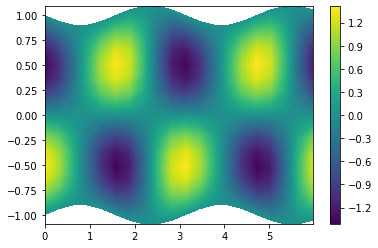

In [15]:
l = 10
u_hat = Function(T)
u_hat[:, :-2] = f[1][:, l].reshape(T.dims())
plt.contourf(xx, yy, u_hat.backward().real, 100)
plt.colorbar()